## Compare shipboard CTD casts to data from OOI platforms downloaded from uFrame

This example will walk you through comparing data downloaded via the OOI Cyberinfrastructure (uFrame) to shipboard CTD cast data. You will learn:

* how to use the platform-to-CTD-cast mapping files in the OOI Datateam Database (https://github.com/seagrinch/data-team-python/tree/master/cruise_data)
* how to access the shipboard CTD cast data files
* how to download data from uFrame via the Machine-to-Machine API
* how to explore and quickly plot the data

Before getting started, login in at https://ooinet.oceanobservatories.org/ and obtain your API username and API token under your profile (top right corner), or use the credentials provided below.

In [1]:
username = 'OOIAPI-D8S960UXPK4K03'
token = 'IXL48EQ2XY'

import pandas as pd
import datetime
from seabird.cnv import fCNV
from geopy.distance import geodesic
import requests
import matplotlib.pyplot as plt

First, specify the sensor (reference designator) and deployment of interest. For this example, we want to look at the beginning of the 2nd deployment of the CTD on the Global Irminger Sea Hybrid Profiler. If you want to look at the shipboard CTD casts that correspond with the recovery of a platform (instead of a deployment), indicate the activity below as 'recovery'. You can navigate to the information you will need for the data request in the [Data Team Database](http://ooi.visualocean.net/).

In [2]:
refdes = 'GI02HYPM-WFP02-04-CTDPFL000'
activity = 'deployment' # or 'recovery'
deployment = 2

Import the cruise mapping files from the Data Team Database (https://github.com/seagrinch/data-team-python/tree/master/cruise_data) and filter the platform-to-CTD-mapping table for the platform and deployment of interest.

* <i>platform_CTDcast_mapping.csv</i> lists each deployment and recovery by platform; the latitude, longitude, cruise ID (CUID) and date from the [OOI Asset Management repo](https://github.com/ooi-integration/asset-management/tree/master/deployment); along with the cruise name (and leg, if applicable) and the CTD cast number(s) that correspond with the deployment/recovery of the platform. <b>Note</b>: the CTD cast information was gathered from cruise reports and is currently only complete for Pioneer and Global platforms.


* <i>cruise_CTDs.csv</i> lists each shipboard CTD cast for each cruise, the date and location of the cast, the path to the Sea-Bird * .cnv file (if available), and the paths to the oxygen and salt data processed on the ship. The format is used for internal purposes and assumes you have a server connection to alfresco.ooi.rutgers.edu on your local machine (/Volumes/webdav/OOI/...), however users without a password can access the data files in [Alfresco](https://alfresco.oceanobservatories.org/).

In [ ]:
cruisedata_repo = 'https://raw.githubusercontent.com/seagrinch/data-team-python/master/cruise_data'
platform_CTD_map = pd.read_csv('/'.join((cruisedata_repo, 'platform_CTDcast_mapping.csv'))).fillna('')

# Filter the platform-to-CTD-mapping table for the platform and deployment of interest
rd = refdes.split('-')
if activity == 'deployment':
    dd = ''.join(('D', '%05d' % deployment))
if activity == 'recovery':
    dd = ''.join(('R', '%05d' % deployment))
    
platform_deploy_info = platform_CTD_map.loc[(platform_CTD_map.platform == rd[0]) & (platform_CTD_map.Deployment == dd)]
platform_deploy_info


The mapping file shows that shipboard CTD cast # 12 on cruise AT-30-01 was done at the time of the 2nd deployment of the Irminger Hybrid Profiler (GI02HYPM). <i>Note: some platform deployments have multiple possible CTD casts associated with them, for others, no CTD casts were identified in the cruise reports.</i> Now, we will use the <i>cruise_CTDs.csv</i> file to get the information for that particular CTD cast.

In [ ]:
cruise = platform_deploy_info.iloc[0]['CTD_CruiseName']
leg = platform_deploy_info.iloc[0]['CTD_CruiseLeg']
cast = platform_deploy_info.iloc[0]['CTDcast']

CTDcasts = pd.read_csv('/'.join((cruisedata_repo, 'cruise_CTDs.csv'))).fillna('')

# select the information from the CTD cast identified in the mapping table
CTDcast_info = CTDcasts.loc[(CTDcasts.CTD_CruiseName == cruise) & (CTDcasts.CTD_CruiseLeg == leg) & (CTDcasts.CTDcast == str(cast))]
CTDcast_info                                                                    

In [ ]:
cnv_filepath = ''.join([CTDcast_info.iloc[0]['filepath_primary'], CTDcast_info.iloc[0]['CTD_rawdata_filepath']])
'Shipboard CTD filepath: {}'.format(cnv_filepath)

Navigate to the location of the Sea-Bird .cnv data file for CTD cast # 12 in [Alfresco](https://alfresco.oceanobservatories.org/) and download the file to your local machine.

![cnv_file_location](../../images/cnv_file_location.png)

In [ ]:
# We will use a package that was written to work with Sea-Bird *.cnv files called seabird. The function to open the 
# *.cnv file is fCNV(<file>). Per the author: 'this is not an official package, so if you have trouble with it, 
# do not complain to Sea-Bird.'
# https://github.com/castelao/seabird

f = '/Users/lgarzio/Documents/OOI/CruiseData/at30_012.cnv' # change this filepath
ctddata = fCNV(f)
ctddata.attributes # list the attributes from the file

In [ ]:
# We can grab the location of the profiler mooring from the Asset Management information table above 
# ('platform_deploy_info') and compare it to the attributes from the shipboard CTD file. This will show us how close
# the CTD cast was done to the profiler mooring. In this case, we're calculating the distance in kilometers.

platform_loc = [platform_deploy_info.iloc[0]['lat'], platform_deploy_info.iloc[0]['lon']]
ctd_cast_loc = [ctddata.attributes['LATITUDE'], ctddata.attributes['LONGITUDE']]
geodesic(platform_loc, ctd_cast_loc).kilometers

In [ ]:
ctddata.keys() # list the variables in the .cnv file

In [9]:
# Select the data from the shipboard CTD file that you would like to plot. In this example, we will select pressure
# and temperature to create a profile plot.

ctd_cast_pres = ctddata['PRES'].data
ctd_cast_temp = ctddata['TEMP'].data
ctd_cast_sal = ctddata['PSAL'].data

We already know the reference designator for the data request, however we also need to select the delivery method and data stream. You can navigate to the information you will need for the data request in the [Data Team Database](http://ooi.visualocean.net/). We will request the recovered data from the science data stream, highlighted below.

![GI02HYPM-WFP02-04-CTDPFL000](../../images/GI02HYPM-WFP02-04-CTDPFL000.png)

In [ ]:
API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
method = 'recovered_wfp'
stream = 'ctdpf_ckl_wfp_instrument_recovered'

request_url = '{:s}{:s}/{:s}/{:s}-{:s}/{:s}/{:s}'.format(API_BASE_URL, rd[0], rd[1], rd[2], rd[3], method, stream)

# We only want data from the same date as the shipboard CTD cast,so we can specify the start and end date for the 
# data request in the params, as well as limit the request to return 1,000 data points.

params = {
    'beginDT': ctddata.attributes['datetime'].strftime('%Y-%m-%dT00:00:00.000Z'),
    'endDT': (ctddata.attributes['datetime'] + datetime.timedelta(days=1)).strftime('%Y-%m-%dT00:00:00.000Z'),
    'limit': 1000
}

# Send the data request, this may take several seconds
r = requests.get(request_url, params=params, auth=(username, token))

if r.status_code != 200: # if the request fails
    print r.json()['message']
elif r.status_code == 200: # if the request is successful
    uframe_data = r.json()
    print 'Request successful!'

In [ ]:
# list the parameter names
uframe_data[0].keys()

Now, we want to go through each element of the JSON response and build lists containing the data we want. If you're unsure about the names of the parameters listed above, click on the stream name in the [Data Team Database](http://ooi.visualocean.net/) highlighted in the image above for more information. Alternatively, you can download a netCDF file that has descriptive parameter attributes through https://ooinet.oceanobservatories.org/ or via the API (as outlined in other notebooks in this repo).

In [ ]:
uframe_time = []
uframe_pres = []
uframe_temp = []
uframe_sal = []

# Function to convert seconds to datetime
def ntp_seconds_to_datetime(ntp_seconds):
    ntp_epoch = datetime.datetime(1900, 1, 1)
    unix_epoch = datetime.datetime(1970, 1, 1)
    ntp_delta = (unix_epoch - ntp_epoch).total_seconds()
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

for i in range(len(uframe_data)):
    uframe_time.append(ntp_seconds_to_datetime(uframe_data[i]['time']))
    uframe_pres.append(uframe_data[i]['ctdpf_ckl_seawater_pressure'])
    uframe_temp.append(uframe_data[i]['ctdpf_ckl_seawater_temperature'])
    uframe_sal.append(uframe_data[i]['practical_salinity'])

# Check the time range of the data received
print 'uFrame data time range: {} to {}'.format(min(uframe_time).strftime('%Y-%m-%dT%H:%M:%SZ'), 
                                                max(uframe_time).strftime('%Y-%m-%dT%H:%M:%SZ'))

# Reminder of the time of the shipboard CTD cast
print 'Shipboard CTD cast time: {}'.format(ctddata.attributes['datetime'].strftime('%Y-%m-%dT%H:%M:%SZ'))

In this case, the data time ranges don't overlap exactly, but it should be close enough to make a general comparison. Now we can plot the data.

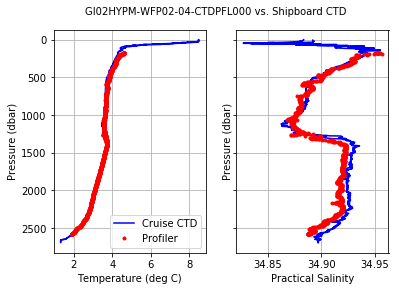

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(ctd_cast_temp, ctd_cast_pres, 'b', label='Cruise CTD')
ax1.plot(uframe_temp, uframe_pres, 'r.', label='Profiler')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Temperature (deg C)')
ax1.invert_yaxis()
ax1.grid()
ax1.legend(loc='best')

ax2.plot(ctd_cast_sal, ctd_cast_pres, 'b')
ax2.plot(uframe_sal, uframe_pres, 'r.')
ax2.set_ylabel('Pressure (dbar)')
ax2.set_xlabel('Practical Salinity')
ax2.grid()

fig.suptitle('{} vs. Shipboard CTD'.format(refdes), fontsize=10)
fig.subplots_adjust(top=0.9)
plt.show()